# Universidad ICESI 
## Facultad de Ingenieria y diseño
### Maestria en ciencia de datos
### Fundamentos de Análitica de Datos II

#### Nombres: 
- Laura Loaiza 
- Mauricio Gutierrez Piedrahita



### Se requiere desarrollar un modelo predictivo que tiene que determinar la localización de perros y gatos que aparecen en una imagen. Se le proporciona un conjunto de datos que contiene imágenes y sus anotaciones correspondientes. Su modelo debe detectar qué tipo de mascota es y dónde se encuentra.

In [2]:
!pip install torchsummary

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function, division

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
# Import albumentations library in order to -use pre-built augmentations
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

plt.ion()   # interactive mode

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for root, dirs, filenames in os.walk('/kaggle/input'):
    for i, filepath in enumerate(filenames):
        if i >= 10:
            print()
            break
        print(osp.join(root, filepath))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/af-ii-2023-ii-object-localization/dataset/sample_submission.csv
/kaggle/input/af-ii-2023-ii-object-localization/dataset/train.csv
/kaggle/input/af-ii-2023-ii-object-localization/dataset/test.csv
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.3370.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.3386.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.8905.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.8943.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.732.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.758.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.660.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.618.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.726.jpg
/kaggle/input/af-ii-2023-ii-object-localization/dataset/images/image.774.jpg



## Creating dataset structure

In [4]:
torch.manual_seed(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
test = torch.ones((100, 100)).to(device)
del test
torch.cuda.empty_cache()

Using cuda


This is done in order to control randomness.

Aquí está el directorio y se define el tamaño de las imagenes y se escoge la validacion de test y train

In [5]:
DATA_DIR = '/kaggle/input/af-ii-2023-ii-object-localization/dataset'
WORK_DIR = '/kaggle/working'
BATCH_SIZE = 32

img_dir = osp.join(DATA_DIR, "images")
h, w, c = 256, 256, 3 # The heigh, width and number of channels of each image

# Here we map each class to an index from 0 to n_classes - 1
obj2id = {
    "cat": 0, 
    "dog": 1
}

id2obj = {
    0: "cat", 
    1: "dog"
}

df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))
df["class_id"] = df["class"].map(obj2id)

df[["xmin", "ymin", "xmax", "ymax"]] /= h

train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25#, random_state=RANDOM_SEED
)

print(train_df.shape)
print(val_df.shape)

test = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

os.listdir(DATA_DIR)

(756, 7)
(252, 7)


['sample_submission.csv', 'images', 'train.csv', 'test.csv']

In [6]:
classes = df["class"].unique()
classes

array(['dog', 'cat'], dtype=object)

The training set contians information about the class at each image and the corresponding bounding box.

In [7]:
df.shape

(1008, 7)

In [8]:
df.head()

filename class      xmin      ymin      xmax      ymax  class_id
0  image.3240.jpg   dog  0.053531  0.016949  0.980085  0.966102         1
1   image.273.jpg   cat  0.021893  0.041808  1.000000  0.983051         0
2   image.775.jpg   cat  0.007203  0.015537  0.768362  1.000000         0
3   image.733.jpg   cat  0.149011  0.000000  0.718503  0.995480         0
4  image.3262.jpg   dog  0.085170  0.176271  0.625283  1.000000         1

In [9]:
import torch
print(torch.__version__)


2.0.0


But the test set only contains the filename of each image, so we have to generate predictions and send it to the Kaggle competition.

In [10]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class PetsDataset(Dataset):
    """
    Location Pets dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        # Convert from BGR to RGB
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        sample = {'image': image}
        
        if self.labeled:
            # Read labels
            img_class = self.df.class_id.iloc[idx]
            #name_class = self.df['class'].iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]

            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})#,'name_class':name_class
        
        if self.transform:
            sample = self.transform(sample)## data aumentation
        
        return sample

In [11]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor: int = 227):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)): 
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX, 
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

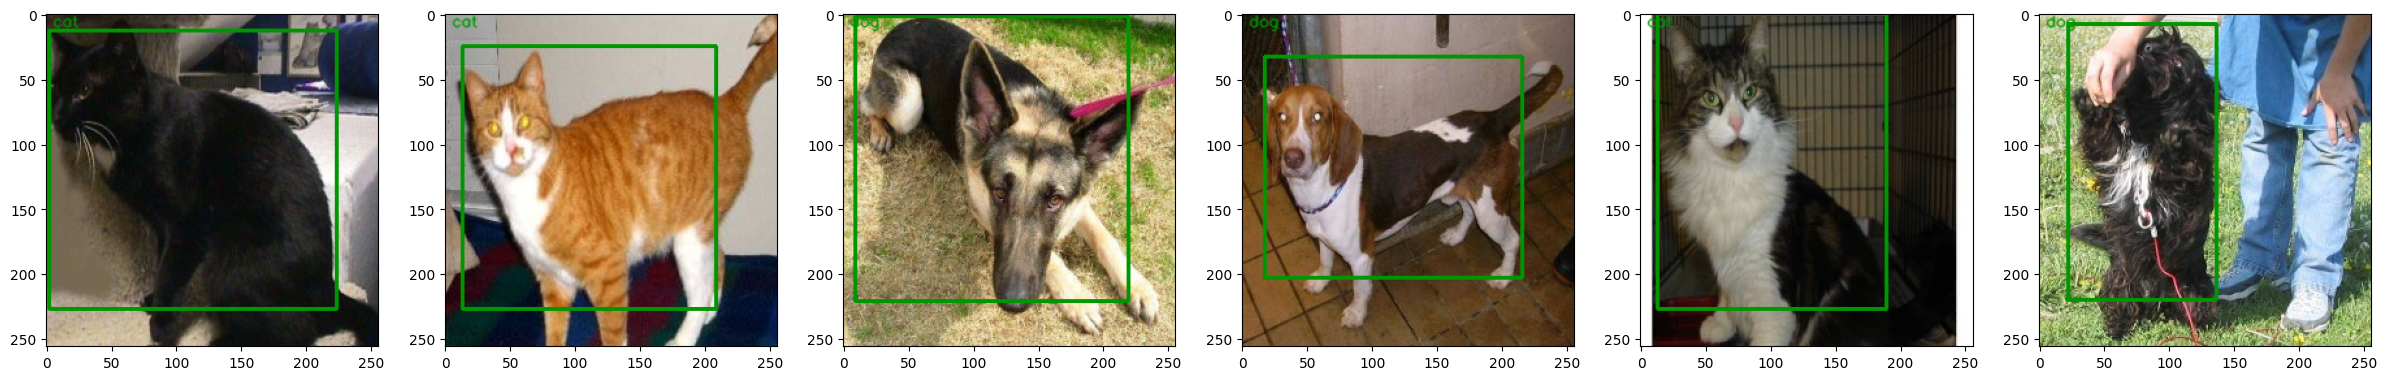

In [12]:
train_root_dir = osp.join(DATA_DIR, "images")#, "train"
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

num_imgs = 6
start_idx = 0

samples = [train_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))#(150, 10)

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

In [13]:
samples[2]['class_id']

array([1])

# Transfer learning (model 1 Transfer learning )

El Transfer Learning con VGG16 permite tomar ventaja de la capacidad de aprendizaje profundo que posee un modelo entrenado en un conjunto de datos masivo y aplicar ese conocimiento a problemas específicos con conjuntos de datos más pequeños. Esto es especialmente útil cuando se dispone de pocos datos o recursos limitados para entrenar un modelo desde cero.

In [14]:
from torchvision.models import vgg16


class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract VGG-16 Feature Layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # Extract VGG-16 Average Pooling Layer
        self.pooling = model.avgpool
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
  
    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.dropout(out) 
        return out 

# Load the vgg16 model
vgg16_model = vgg16(pretrained=True, progress=True)
pretrained_model = FeatureExtractor(vgg16_model).to(device)
pretrained_model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.7MB/s] 


FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [15]:
summary(pretrained_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 227, 227]           1,792
              ReLU-2         [-1, 64, 227, 227]               0
            Conv2d-3         [-1, 64, 227, 227]          36,928
              ReLU-4         [-1, 64, 227, 227]               0
         MaxPool2d-5         [-1, 64, 113, 113]               0
            Conv2d-6        [-1, 128, 113, 113]          73,856
              ReLU-7        [-1, 128, 113, 113]               0
            Conv2d-8        [-1, 128, 113, 113]         147,584
              ReLU-9        [-1, 128, 113, 113]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Image normalization

In [17]:
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

means = None # [192.7398838152939, 190.94339673431622, 181.09955913748954]
stds = None # [83.23730414690347, 84.07248256814508, 92.48922372831]

if means is None and stds is None:
    means, stds = [], []
    pixel_values = [
        [], # R, size = H * W * num_images 
        [], # G size = H * W * num_images
        [], # B size = H * W * num_images
    ]

    for x in train_ds:
        img = x['image']

        for channel in range(3):
            channel_pixel_values = list(img[..., channel].flatten())
            pixel_values[channel].extend(channel_pixel_values)

    for channel in range(3):
        means.append(np.mean(pixel_values[channel]))
        stds.append(np.std(pixel_values[channel]))
    
    del pixel_values

In [18]:
print(means)
print(stds)

[125.5118483689727, 116.40442229578734, 106.58990553194883]
[66.59736435881096, 65.13649847961914, 66.15757270420256]


(256, 256, 3)
(3, 256, 256)


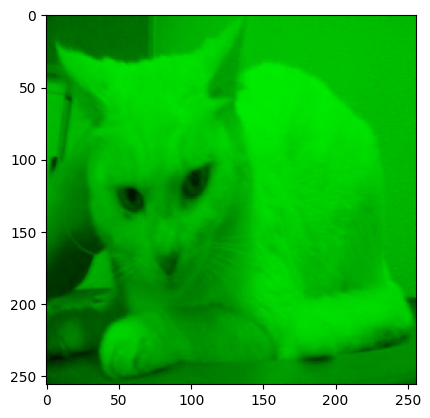

In [19]:
img_filename = osp.join(DATA_DIR, "images",'image.13.jpg')
img1 = cv2.imread(img_filename)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

print(img1.shape)
print(img1.transpose((2,0,1)).shape)
img1[..., 0] = 0
img1[..., 2] = 0

plt.imshow(img1)

# Image transforms

In [20]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C (0,1,2)
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        sample.update({'image': image})
        return sample

class Normalizer(object):
    
    def __init__(self, stds, means):
        """
        Arguments:
        
            stds: array of length 3 containing the standard deviation of each channel in RGB order.
            means: array of length 3 containing the means of each channel in RGB order.
        """
        self.stds = stds
        self.means = means
    
    def __call__(self, sample):
        """
        Sample: a dicitonary containing:
            image: sample image in format (C, H, W)
        Returns:
            the image in (C, H, W) format with the channels normalized.
        """
        image = sample['image']
        
        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample

class TVTransformWrapper(object):
    """Torch Vision Transform Wrapper
    """
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform
        
    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample

class AlbumentationsWrapper(object):
    
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, sample):
        transformed = self.transform(
            image=sample['image'], 
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']
        )
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample

In [21]:
common_transforms = [    
    ToTensor(),
    Normalizer(
        means=means,
        stds=stds,
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.01, p=0.5),
    A.ImageCompression(p=0.5),
    A.Rotate(limit=(-20,20), p=0.5),
    A.Affine(translate_percent={'x':(-0.25, 0.25),'y':(-0.25, 0.25)}, p=0.5),
    A.Resize(height=256, width=256, p=1) # p=1 means always apply
    ],
    bbox_params=A.BboxParams(
        format='albumentations', 
        label_fields=[],#'category_ids'
    )
)

train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),
    ] + common_transforms
)

eval_transforms = torchvision.transforms.Compose(common_transforms)

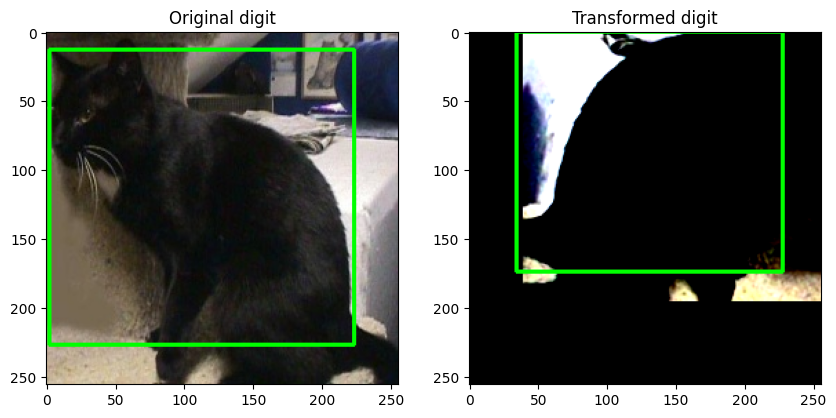

In [22]:
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

x = next(iter(train_ds))
x_transformed = copy.deepcopy(x)
x_transformed = train_transforms(x_transformed)

original_img = x['image']
transformed_img = x_transformed['image'].numpy().transpose(1, 2, 0)

original_img = draw_bbox(
    original_img,
    normalize_bbox(x['bbox'].squeeze()),
    (0, 255, 0)
)

transformed_img = draw_bbox(
    transformed_img,
    normalize_bbox(x_transformed['bbox'].squeeze()),
    (0, 255, 0)
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(original_img)
axes[0].set_title('Original digit')

axes[1].imshow(transformed_img)
axes[1].set_title('Transformed digit')

plt.show()

In [24]:
train_ds = PetsDataset(df, root_dir=train_root_dir, transform=train_transforms)
train_data = torch.utils.data.DataLoader(train_ds, batch_size=32)

for x in train_data:
    print(x['image'].size())
    break


torch.Size([32, 3, 256, 256])


In [25]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 256, 256), n_classes: int = 2):
        """
        Model with one input (image) and two outputs: 
            1. Digit classification (classification).
            2. Bounding box prediction (regression). 
        
        Arguments:
            input_shape: input shape of the image in format (C, H, W)
            n_classes: number of classes to perfrom classification with
            
        Attributes:
            backbone: ConvNet that process the image and 
            returns a flattened vector with the information of the 
            activations.
            
            cls_head: MLP that receives the flattened input from the backbone 
            and predicts the classification logits for the classes (classficiation task).
            
            reg_head: MLP that receives the flattened input from the backbone 
            and predicts the coordinates of the predicted bounding box (regression task). 
        """
        super().__init__()
        
        self.input_shape = input_shape
        
        # When doing transfer learning, use pretrained model instead of custom backbone
        self.backbone = pretrained_model
        
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
        
        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

In [26]:
print('image', x['image'].size())
model = Model(input_shape=(3, 256, 256), n_classes=2).to(device)
x['image'] = x['image'].to(device)
preds = model(x['image'])
preds

image torch.Size([32, 3, 256, 256])


{'bbox': tensor([[ 0.0746, -0.0047, -0.0970, -0.0651],
         [-0.0399,  0.0813, -0.0956, -0.0274],
         [ 0.0029,  0.0083, -0.0411, -0.0610],
         [ 0.0053,  0.0654, -0.0676, -0.0353],
         [ 0.0456,  0.0676, -0.0653, -0.0649],
         [ 0.0035,  0.0456, -0.0588, -0.0766],
         [ 0.0019,  0.0182, -0.0806,  0.0043],
         [ 0.0396,  0.0428, -0.1479, -0.0371],
         [ 0.0462,  0.0710, -0.0705, -0.0410],
         [-0.0360, -0.0353, -0.0828,  0.0289],
         [ 0.0440,  0.0248, -0.1207, -0.0145],
         [ 0.0251,  0.0074, -0.1472, -0.0503],
         [ 0.0399, -0.0043, -0.2262, -0.0309],
         [ 0.0308,  0.0617, -0.1041, -0.0903],
         [ 0.0044,  0.0648, -0.0801,  0.0119],
         [-0.0368,  0.0500, -0.1188, -0.0068],
         [ 0.0241, -0.0012, -0.0650, -0.0214],
         [-0.0104,  0.0237, -0.1446, -0.0096],
         [ 0.0799,  0.0410, -0.1578, -0.1401],
         [-0.0165,  0.0428, -0.1256, -0.0077],
         [-0.0064,  0.0095, -0.0993,  0.0133],
     

# Metrics

In [27]:
def iou(y_true: Tensor, y_pred: Tensor):
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result

In [28]:
def accuracy(y_true: Tensor, y_pred: Tensor):
    pred = torch.argmax(y_pred, axis=-1)
    y_true = y_true.squeeze()
    correct = torch.eq(pred, y_true).float()
    total = torch.ones_like(correct)
    result = torch.divide(torch.sum(correct), torch.sum(total))
    return result

# Loss fn

In [29]:
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    cls_y_true, cls_y_pred = y_true['class_id'].long(), y_preds['class_id'].float().unsqueeze(-1)
    reg_y_true, reg_y_pred = y_true['bbox'].float().squeeze(), y_preds['bbox'].float().squeeze()
    
    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)
    
    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)
    # Adds weights to both tasks
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return dict(loss=total_loss, reg_loss=reg_loss,cls_loss=cls_loss)

# Callbacks

In [30]:
def printer(logs: ty.Dict[str, ty.Any]):
    # print every 10 steps
    if logs['iters'] % 10 != 0:
        return
    print('Iteration #: ',logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue
        
        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)
        
        print(f'\t{name} = {value}')
    print()

# Training loop

In [31]:
def evaluate(
    logs: ty.Dict[str, ty.Any], 
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:
    
    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value
    
    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value
            
    return logs

def step(
    model: Model, 
    optimizer: Optimizer, 
    batch: PetsDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:
    
    if train:
        optimizer.zero_grad()
    
    img = batch.pop('image').to(device)
    
    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)
    
    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']
    
    if train:
        final_loss.backward()
        optimizer.step()
    
    return losses, preds


def train(
    model: Model, 
    optimizer: Optimizer, 
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: 100,
    eval_steps: 10,
) -> Model:
    # Send model to device (GPU or CPU)
    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'
    
    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)
        # Send batch to device 
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)
        
        # Eval every eval_steps iterations
        if iters % eval_steps == 0:        
            # Evaluate
            # Deactives layers that only needed to train
            # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615
            model.eval()
            
            # Avoids calculating gradients in evaluation dataset. 
            with torch.no_grad():

                for name, dataset in eval_datasets:
                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)            
                        logs = evaluate(logs, batch, preds, name, metrics, losses)
        
        for callback in callbacks:
            callback(logs)
        
        iters += 1
    
    return model

# Run

In [32]:
# Hparams
batch_size = 32
lr = 0.00001

# Data
train_ds = PetsDataset(train_df, root_dir=train_root_dir, transform=train_transforms)
val_ds = PetsDataset(val_df, root_dir=train_root_dir, transform=eval_transforms)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [33]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=200,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.5878999829292297
	train_reg_loss = 0.4812999963760376
	train_cls_loss = 0.6945000290870667
	train_iou = 0.0
	train_accuracy = 0.625
	val_loss = 0.5436999797821045
	val_reg_loss = 0.42399999499320984
	val_cls_loss = 0.6633999943733215
	val_iou = 0.0
	val_accuracy = 0.75

Iteration #:  10
	train_loss = 0.2524000108242035
	train_reg_loss = 0.09839999675750732
	train_cls_loss = 0.4065000116825104
	train_iou = 0.1953
	train_accuracy = 0.9688000082969666
	val_loss = 0.1834000051021576
	val_reg_loss = 0.03539999946951866
	val_cls_loss = 0.3314000070095062
	val_iou = 0.4752
	val_accuracy = 0.928600013256073

Iteration #:  20
	train_loss = 0.0868000015616417
	train_reg_loss = 0.03420000150799751
	train_cls_loss = 0.13930000364780426
	train_iou = 0.5034
	train_accuracy = 0.9688000082969666
	val_loss = 0.09769999980926514
	val_reg_loss = 0.053300000727176666
	val_cls_loss = 0.1421000063419342
	val_iou = 0.4529
	val_accuracy = 0.928600013256073

Iteration #:  30
	tr

In [34]:
num_imgs = 5
ncols = 5
nrows = math.ceil(num_imgs / ncols)

start_idx = 0

inference_ds = PetsDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir)
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)
inference_batch = next(iter(inference_data))
inference_imgs = np.empty((num_imgs, 3, 256, 256))

transform = eval_transforms

for i, img in enumerate(inference_batch['image']):
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

preds = model(torch.tensor(inference_imgs).float().to(device))

samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox) for bbox in pred_bboxes]
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()

In [35]:
inference_imgs.shape

(5, 3, 256, 256)

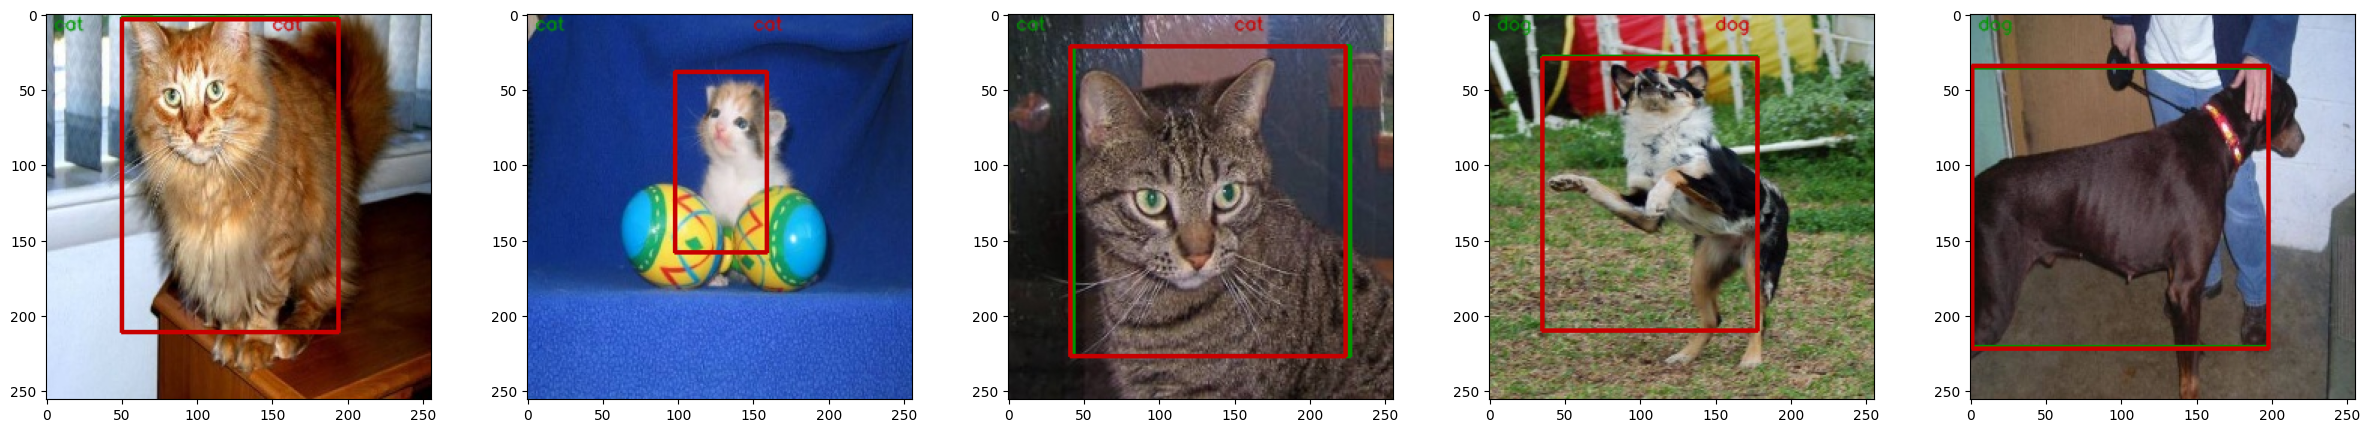

In [36]:
# Green: ground truth
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))
# Red: predicted

pred_classes_=[]
for i in range(0,num_imgs-1):
    temp=np.array([pred_classes[i]])
    pred_classes_.append(temp)
imgs = draw_predictions(imgs, pred_classes_, pred_bboxes, [(200, 0, 0)], (150, 10))

fig = plt.figure(figsize=(30*nrows, num_imgs))
k, j = 1, 1

for img in imgs:
    if j > ncols and k < nrows:
        k += 1
        j = 1
    fig.add_subplot(k, num_imgs, j)
    plt.imshow(img)
    j += 1

plt.show()

La superposición de los cuadrados, casi sin separación entre las predicciones del modelo (rojo) y las etiquetas verdaderas (verde) es un signo positivo en la evaluación del desempeño del modelo. Esta alineación entre las predicciones y las verdaderas etiquetas podría es un indicio de que el modelo es capaz de identificar y localizar con precisión las regiones en las que se encuentran los animales (gato y pero) que deseamos clasificar.

In [37]:
!wget https://upload.wikimedia.org/wikipedia/commons/d/dc/Canis_lupus_familiaris_Perro_Mestizo.JPG
!ls

--2023-11-04 22:09:07--  https://upload.wikimedia.org/wikipedia/commons/d/dc/Canis_lupus_familiaris_Perro_Mestizo.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3089435 (2.9M) [image/jpeg]
Saving to: ‘Canis_lupus_familiaris_Perro_Mestizo.JPG’

Canis_lupus_familia 100%[===================>]   2.95M  4.21MB/s    in 0.7s    

2023-11-04 22:09:08 (4.21 MB/s) - ‘Canis_lupus_familiaris_Perro_Mestizo.JPG’ saved [3089435/3089435]

Canis_lupus_familiaris_Perro_Mestizo.JPG


In [38]:
pickle_rick_img = cv2.imread('Canis_lupus_familiaris_Perro_Mestizo.JPG')
pickle_rick_img = cv2.resize(pickle_rick_img, (h, w))
pickle_rick_img_=np.expand_dims(pickle_rick_img.transpose(2,0,1), 0)

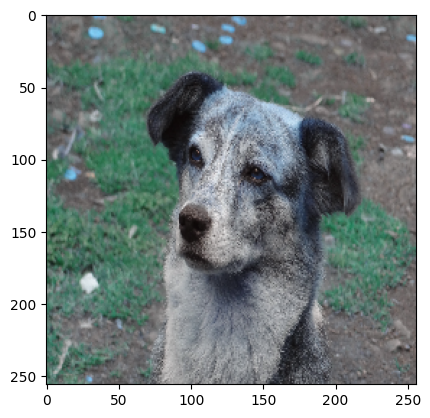

In [39]:
plt.imshow(pickle_rick_img)

In [40]:
pickle_rick_img.shape, pickle_rick_img_.shape

((256, 256, 3), (1, 3, 256, 256))

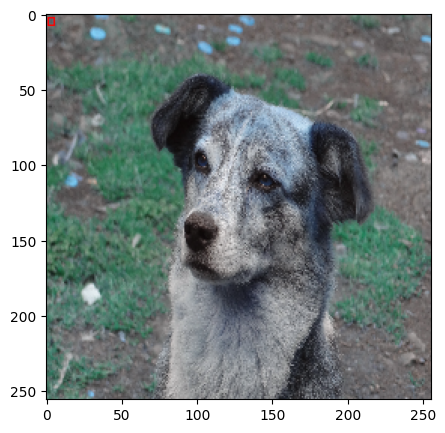

In [41]:
preds = model(torch.tensor(pickle_rick_img_).float().to(device))
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()
pred_bboxes = preds['bbox'].detach().cpu().numpy().tolist()
pred_class = id2obj[pred_classes[0]]
xmin=int(pred_bboxes[0][0])
ymin=int(pred_bboxes[0][1])
xmax=int(pred_bboxes[0][2])
ymax=int(pred_bboxes[0][3])
pickle_rick_img = cv2.rectangle(pickle_rick_img, (xmin, ymin), (xmax, ymax), (255, 0, 0))
pickle_rick_img = cv2.putText(pickle_rick_img, pred_class, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(5, 5))
plt.imshow(pickle_rick_img)
#plt.axis("off")
plt.show()

In [43]:
# Save the model to disk
torch.save(model, 'pretrained_model.pth')

# Submission

In [44]:
# Perform inference on cpu in order to avoid memory problems 
device = 'cuda'
model = model.to(device)

test_root_dir = osp.join(DATA_DIR, "images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

test_ds = PetsDataset(test_df, root_dir=test_root_dir, labeled=False, transform=eval_transforms)
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

class_preds = []
bbox_preds = []

for batch in test_data:
    batch_preds = model(batch['image'].float().to(device))
    
    class_pred = batch_preds['class_id'].argmax(-1).detach().cpu().numpy()
    bbox_pred = batch_preds['bbox'].detach().cpu().numpy()
    
    class_preds.append(class_pred.squeeze())
    bbox_preds.append(bbox_pred.squeeze())

In [45]:
class_preds = np.array(class_preds)
bbox_preds = np.array(bbox_preds)

In [46]:
submission = pd.DataFrame(
    index=test_df.filename,
    data={
        'class': class_preds,
        # Descomentar esta línea cuando generen el archivo de submissions final, 
        # para incluir las predicciones de su modelo para regresión  
        #'bbox': bbox_preds
    }
)
submission

class
filename             
image.3401.jpg      1
image.3325.jpg      1
image.3242.jpg      1
image.3218.jpg      1
image.797.jpg       0
...               ...
image.839.jpg       0
image.892.jpg       0
image.689.jpg       0
image.171.jpg       1
image.3379.jpg      1

[192 rows x 1 columns]

In [47]:
submission['class']=submission['class'].replace(id2obj)

In [48]:
submission

class
filename            
image.3401.jpg   dog
image.3325.jpg   dog
image.3242.jpg   dog
image.3218.jpg   dog
image.797.jpg    cat
...              ...
image.839.jpg    cat
image.892.jpg    cat
image.689.jpg    cat
image.171.jpg    dog
image.3379.jpg   dog

[192 rows x 1 columns]

In [ ]:
submission.to_csv('submission.csv')

In [ ]:
submission["x_min"] = bbox_preds[:, 0]*h
submission["y_min"] = bbox_preds[:, 1]*h
submission["x_max"] = bbox_preds[:, 2]*h
submission["y_max"] = bbox_preds[:, 3]*h

In [ ]:
submission

## CNN PERSONALIZADA #1

 ### Con dos capas, (lineales, Relu )

In [49]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 256, 256), n_classes: int = 2):
        """
        Model with one input (image) and two outputs: 
            1. Digit classification (classification).
            2. Bounding box prediction (regression). 
        
        Arguments:
            input_shape: input shape of the image in format (C, H, W)
            n_classes: number of classes to perfrom classification with
            
        Attributes:
            backbone: ConvNet that process the image and 
            returns a flattened vector with the information of the 
            activations.
            
            cls_head: MLP that receives the flattened input from the backbone 
            and predicts the classification logits for the classes (classficiation task).
            
            reg_head: MLP that receives the flattened input from the backbone 
            and predicts the coordinates of the predicted bounding box (regression task). 
        """
        super().__init__()
        
        self.input_shape = input_shape
        
        # When doing transfer learning, use pretrained model instead of custom backbone
        self.backbone = pretrained_model
        
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
        
        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions
    

#### Acuraccy=0,6786 primeras aproximaciones, a partir de la iteración 40 convergia a 1.

## CNN Personalizada # 2

 ### Con 4 convoluciones, maxpooling en cada una de las capas convoluciones, 2 capas densas con funcion lineal.

In [51]:
class BinaryImageClassifierBase(nn.Module):
    def __init__(self):
        super().__init__()    

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        logits = self.linear2(x)
        ##probas = torch.sigmoid(logits)

        return logits

# Crear una instancia del modelo
pretrained_model= BinaryImageClassifierBase().to(device)



#### Acuraccy=1.0,  desde la iteracción 1. 
Esta arquitectura de modelo ha sido con la que se han obtenido mejores métricas con respecto al accuracy.

In [52]:
modelo_base = BinaryImageClassifierBase()
modelo_base

BinaryImageClassifierBase(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6272, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [53]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=modelo_base.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.01940000057220459
	train_reg_loss = 0.020500000566244125
	train_cls_loss = 0.018400000408291817
	train_iou = 0.5743
	train_accuracy = 1.0
	val_loss = 0.00019999999494757503
	val_reg_loss = 0.0
	val_cls_loss = 0.0003000000142492354
	val_iou = 0.9905
	val_accuracy = 1.0

Iteration #:  10
	train_loss = 0.022600000724196434
	train_reg_loss = 0.027499999850988388
	train_cls_loss = 0.01769999973475933
	train_iou = 0.5394
	train_accuracy = 1.0
	val_loss = 0.00019999999494757503
	val_reg_loss = 0.0
	val_cls_loss = 0.0003000000142492354
	val_iou = 0.9905
	val_accuracy = 1.0

Iteration #:  20
	train_loss = 0.06129999831318855
	train_reg_loss = 0.01979999989271164
	train_cls_loss = 0.10289999842643738
	train_iou = 0.5777
	train_accuracy = 0.9688000082969666
	val_loss = 0.00019999999494757503
	val_reg_loss = 0.0
	val_cls_loss = 0.0003000000142492354
	val_iou = 0.9905
	val_accuracy = 1.0

Iteration #:  30
	train_loss = 9.999999747378752e-05
	train_reg_loss = 0.0
	tra

## CNN Personalizada 

La arquitectura de este modelo es con 2 capas y 2 convolusiones, con ReLU y Maxpooling después de cada convolución. 

In [54]:
import torch
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self, input_shape=(3, 256, 256), n_classes=2):
        super(MyCNN, self).__init__()
        
        # 
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), 128)  # La división entre 4 se debe a las capas de maxpool
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Aplanar la salida para la capa completamente conectada
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Crear una instancia de tu CNN personalizada
pretrained_model = MyCNN().to(device)

# Imprimir la arquitectura de tu CNN
print(pretrained_model)


MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Acuraccy maximo de 0,57

## CNN personalizada # 3

### CNN con 3 convoluciones, con ReLU y maxpooling después de cada convolución y 2 capas densas con ReLU y función lineal. 

In [58]:
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self, input_shape=(3, 256, 256), n_classes=2):
        super(MyCNN, self).__init__()
        
        # Capas convolucionales y de agrupación
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        
        return x

# Crear una instancia de tu CNN personalizada
pretrained_model = MyCNN().to(device)

# Imprimir la arquitectura de tu CNN
print(pretrained_model)

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


### Acuraccy=0,70

## CNN Personalizada #4 

### CNN con 6 convolusiones, ReLu, maxpooling y 2 capas densas.  

In [59]:
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self, n_classes=2):
        super(MyCNN, self).__init__()
        
        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        # Capas de agrupación
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Capas completamente conectadas
        self.fc1 = nn.Linear(256 * 32 * 32, 512)  # Tamaño de la entrada ajustado a imágenes de 256x256
        self.relu7 = nn.ReLU()
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.fc2(x)
        
        return x

pretrained_model = MyCNN().to(device)

# Imprimir la arquitectura de tu CNN
print(pretrained_model)

MyCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (relu7): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [60]:
# Data
train_ds = PetsDataset(train_df, root_dir=train_root_dir, transform=train_transforms)
val_ds = PetsDataset(val_df, root_dir=train_root_dir, transform=eval_transforms)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [61]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=pretrained_model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.5641000270843506
	train_reg_loss = 0.43050000071525574
	train_cls_loss = 0.697700023651123
	train_iou = 0.0
	train_accuracy = 0.46880000829696655
	val_loss = 1.5120999813079834
	val_reg_loss = 0.2786000072956085
	val_cls_loss = 2.745500087738037
	val_iou = 0.0651
	val_accuracy = 0.321399986743927

Iteration #:  10
	train_loss = 0.35249999165534973
	train_reg_loss = 0.026900000870227814
	train_cls_loss = 0.6780999898910522
	train_iou = 0.5116
	train_accuracy = 0.625
	val_loss = 0.3619000017642975
	val_reg_loss = 0.017500000074505806
	val_cls_loss = 0.7063999772071838
	val_iou = 0.6137
	val_accuracy = 0.321399986743927

Iteration #:  20
	train_loss = 0.34860000014305115
	train_reg_loss = 0.012900000438094139
	train_cls_loss = 0.6841999888420105
	train_iou = 0.637
	train_accuracy = 0.625
	val_loss = 0.34549999237060547
	val_reg_loss = 0.013100000098347664
	val_cls_loss = 0.6779999732971191
	val_iou = 0.617
	val_accuracy = 0.678600013256073

Iteration #:  30

### Acuraccy máximo de 0,75

## Modelo  2 de transfer learning 

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader


In [63]:
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract ResNet-50 Feature Layers (remove the final fully connected layer)
        self.features = nn.Sequential(*list(model.children())[:-2])
        # Global Average Pooling (GAP) layer to replace avgpool
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
  
    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.global_avgpool(out)
        return out


In [64]:
from torchvision.models import densenet121

resnet50_model= models.resnet50(pretrained=True)

resnet50_model = FeatureExtractor(resnet50_model).to(device)
resnet50_model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 64.9MB/s]


FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [65]:
batch_size = 32
lr = 0.0001

# Data
train_ds = PetsDataset(train_df, root_dir=train_root_dir, transform=train_transforms)
val_ds = PetsDataset(val_df, root_dir=train_root_dir, transform=eval_transforms)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [66]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=resnet50_model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.5874000191688538
	train_reg_loss = 0.48240000009536743
	train_cls_loss = 0.692300021648407
	train_iou = 0.0
	train_accuracy = 0.5311999917030334
	val_loss = 0.5649999976158142
	val_reg_loss = 0.4602999985218048
	val_cls_loss = 0.669700026512146
	val_iou = 0.0
	val_accuracy = 0.678600013256073

Iteration #:  10
	train_loss = 0.5055999755859375
	train_reg_loss = 0.35409998893737793
	train_cls_loss = 0.6571000218391418
	train_iou = 0.0022
	train_accuracy = 0.7188000082969666
	val_loss = 0.4803999960422516
	val_reg_loss = 0.32280001044273376
	val_cls_loss = 0.6380000114440918
	val_iou = 0.0014
	val_accuracy = 0.7142999768257141

Iteration #:  20
	train_loss = 0.4666999876499176
	train_reg_loss = 0.20430000126361847
	train_cls_loss = 0.7289999723434448
	train_iou = 0.0776
	train_accuracy = 0.6561999917030334
	val_loss = 0.37540000677108765
	val_reg_loss = 0.16680000722408295
	val_cls_loss = 0.583899974822998
	val_iou = 0.1013
	val_accuracy = 0.75

Iteration #

## CNN Personalizada #5 

### CNN personalizada con 4 convolusiones y 2 capas densas. Para este modelo se crean dos dropouts, uno a la salida del último Maxpooling de la última convolución y otro dropout en la salida de la 1 capa densa. 

In [67]:
class BinaryImageClassifierBase_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
#SE CREA EL DROPOUT EN LA SALIDA DEL MAXPOOLING
        self.dropout1 = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
#Y EN LA SALIDA DE LA CAPA DENSA
        self.dropout2 = nn.Dropout(p=0.5) #(PUEDE ESTAR ENTRE EL 10% Y 50%)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        logits = self.linear2(x)
        probas = torch.sigmoid(logits)

        return probas

In [68]:
modelo_base_dropout = BinaryImageClassifierBase_Dropout()
modelo_base_dropout.to(device)

BinaryImageClassifierBase_Dropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6272, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [69]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=modelo_base_dropout.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.6679999828338623
	train_reg_loss = 0.016100000590085983
	train_cls_loss = 1.3199000358581543
	train_iou = 0.611
	train_accuracy = 0.4375
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration #:  10
	train_loss = 0.4074000120162964
	train_reg_loss = 0.01209999993443489
	train_cls_loss = 0.8026999831199646
	train_iou = 0.6534
	train_accuracy = 0.6561999917030334
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration #:  20
	train_loss = 0.4474000036716461
	train_reg_loss = 0.020400000736117363
	train_cls_loss = 0.8744000196456909
	train_iou = 0.5891
	train_accuracy = 0.6875
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration 

## CNN Personalizada #6

### Arquitectura con 4 convoluciones, cada convulusion tiene una capa de batch normalization, tiene 4 maxpooling y 2 capas densas, en este caso el droupt se realiza en las capas densas

In [1]:
class BinaryImageClassifierBase_BNormDropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="valid")
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid")
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="valid")
        self.conv4_bn = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.linear1_bn = nn.BatchNorm1d(512)

        self.dropout2 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=512, out_features=1)

    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(self.conv1_bn(x))
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.maxpool4(x)

        x = self.dropout1(x)
        x = self.flatten(x)

        x = self.linear1(x)
        x = F.relu(self.linear1_bn(x))
        x = self.dropout1(x)

        logits = self.linear2(x)
        probas = torch.sigmoid(logits)
        return probas

NameError: name 'nn' is not defined

In [71]:
dropout_norm = BinaryImageClassifierBase_BNormDropout()
dropout_norm.to(device)

BinaryImageClassifierBase_BNormDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpoo

In [72]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=dropout_norm.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.3783000111579895
	train_reg_loss = 0.013100000098347664
	train_cls_loss = 0.7434999942779541
	train_iou = 0.6362
	train_accuracy = 0.5625
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration #:  10
	train_loss = 0.6201000213623047
	train_reg_loss = 0.01759999990463257
	train_cls_loss = 1.2226999998092651
	train_iou = 0.5956
	train_accuracy = 0.5
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration #:  20
	train_loss = 0.4239000082015991
	train_reg_loss = 0.018200000748038292
	train_cls_loss = 0.8295999765396118
	train_iou = 0.5875
	train_accuracy = 0.625
	val_loss = 0.1518000066280365
	val_reg_loss = 0.01489999983459711
	val_cls_loss = 0.28870001435279846
	val_iou = 0.6062
	val_accuracy = 0.928600013256073

Iteration #:  30
	train_l

#### Modelos Simples:
- Modelo con Dos Capas (Lineales, ReLU): Presenta solo dos capas, posiblemente una capa lineal seguida de una función de activación ReLU. Es un modelo muy básico con pocas capas.

- Modelo con 2 Capas y 2 Convoluciones (ReLU, Maxpooling):Consta de dos capas y dos capas convolucionales, con ReLU y Maxpooling después de cada convolución. Aunque tiene un enfoque más convolucional, sigue siendo relativamente simple.

#### Modelos Complejos:
- Modelo con 4 Convoluciones y 2 Capas Densas (Maxpooling, Función Lineal): Este modelo destaca por su precisión perfecta (accuracy de 1.0), con 4 capas convolucionales, Maxpooling en cada una de las capas convolucionales y 2 capas densas con función lineal. Puede ser considerado complejo debido a su profundidad y las capas densas.
- Modelo CNN con 3 Convoluciones y 2 Capas Densas (ReLU y Función Lineal): Presenta tres capas convolucionales seguidas de capas de Maxpooling y dos capas densas con ReLU y función lineal. Aunque no tan complejo como el anterior, sigue siendo más elaborado que los modelos simples.

- Transfer Learning (ResNet50): ResNet50 es un modelo pre-entrenado que contiene una arquitectura profunda con 50 capas. Aunque el modelo está pre-entrenado, su complejidad radica en su arquitectura profunda y en las características intrínsecas del modelo pre-entrenado.

- CNN Personalizada con 4 Convoluciones y 2 Capas Densas (Dropouts y Batch Normalization): Utiliza 4 capas convolucionales, capas de Batch Normalization en cada convolución, 4 capas de Maxpooling y 2 capas densas. Además, implementa dropouts en las capas densas para regularización.

Para este caso de estudio, los mejores accuracy obtenidos fueron con un modelo simple y un modelo complejo. La mayoría de modelos personalizados podrían ser considerados como complejos, pero en terminos de accuracy el primer modelo que fue simple superó a varios de los modelos complejos desarrollados en este trabajo. 








### Conclusiones: 

- En este trabajo, se debía desarrollar un modelo predictivo para la detección de perros y gatos en imágenes, tarea conocida como localización y clasificación de mascotas. Se dispuso de un conjunto de datos con imágenes y sus correspondientes anotaciones que indicaban la presencia y ubicación de las mascotas en las imágenes.

- Se exploraron diversas arquitecturas de modelos, variando en la cantidad de capas, combinaciones de capas convolucionales y densas, así como la aplicación de técnicas como ReLU, Maxpooling, Batch Normalization y Dropout. La variación en el learning rate fue parte esencial del proceso de entrenamiento y refinamiento de los modelos.

- Los modelos creados se diferenciaron en su complejidad y número de capas. Desde modelos más simples con dos capas lineales y activaciones ReLU hasta arquitecturas más profundas que incorporaban múltiples capas convolucionales y capas densas con distintas técnicas de regularización.

- Entre los modelos evaluados, se destacó uno en particular (modelo_base) que presentó un rendimiento sobresaliente, logrando un accuracy perfecto de 1.0. Este modelo específico constaba de 4 capas convolucionales con Maxpooling, seguidas por 2 capas densas con funciones lineales.

- Además, se exploró el uso de técnicas avanzadas como transfer learning mediante modelos pre-entrenados, como ResNet50, para aprovechar características aprendidas en conjuntos de datos más grandes y complejos.

Este estudio demostró la importancia de explorar y ajustar arquitecturas de modelos para resolver desafíos de detección y clasificación de mascotas en imágenes, resaltando la influencia de la estructura del modelo y las técnicas de entrenamiento en el rendimiento final de la tarea.





